# Traffic jam exploration
* From the heatmap perspective

In [13]:
%matplotlib inline
import pandas as pd
import gzip
import time
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime 


from skimage import measure
from skimage.filters import roberts, sobel, scharr, prewitt

from scipy import ndimage as ndi

from skimage import feature


In [14]:
#data locations
data_5min_path = "../station_5min/2015/d11/"
meta_path = "../station_5min/2015/meta_data/d11/"

In [15]:
#get all files to process
onlyfiles = [f for f in listdir(data_5min_path) if isfile(join(data_5min_path, f))]

In [16]:
onlyfiles[0:3]

['d11_text_station_5min_2016_01_01.txt.gz',
 'd11_text_station_5min_2016_01_02.txt.gz',
 'd11_text_station_5min_2016_01_03.txt.gz']

In [17]:
colnames = ['Timestamp','Station','District','Freeway','Direction_of_Travel','LaneType',
            'StationLength','Samples', 'Perc_Observed','TotalFlow','AvgOccupancy','AvgSpeed',
            'Lane1_Samples','Lane1_Flow','Lane1_AvgOcc','Lane1_AvgSpeed','Lane1_Observed',
            'Lane2_Samples','Lane2_Flow','Lane2_AvgOcc','Lane2_AvgSpeed','Lane2_Observed',
            'Lane3_Samples','Lane3_Flow','Lane3_AvgOcc','Lane3_AvgSpeed','Lane3_Observed',
            'Lane4_Samples','Lane4_Flow','Lane4_AvgOcc','Lane4_AvgSpeed','Lane4_Observed',
            'Lane5_Samples','Lane5_Flow','Lane5_AvgOcc','Lane5_AvgSpeed','Lane5_Observed',
            'Lane6_Samples','Lane6_Flow','Lane6_AvgOcc','Lane6_AvgSpeed','Lane6_Observed',
            'Lane7_Samples','Lane7_Flow','Lane7_AvgOcc','Lane7_AvgSpeed','Lane7_Observed',
            'Lane8_Samples','Lane8_Flow','Lane8_AvgOcc','Lane8_AvgSpeed','Lane8_Observed',]

## Test on a single file first

In [59]:
#Extract contents of file and read to pandas dataframe
with gzip.open(data_5min_path+onlyfiles[5], 'rb') as f:
    file_content = pd.read_csv(f, header=None,names=colnames)

In [60]:
file_content.shape

(410112, 52)

In [62]:
pd.to_datetime('01/01/2016 00:00:00',format='%m/%d/%Y %H:%M:%S')

Timestamp('2016-01-01 00:00:00')

In [64]:
#filter freeway to I5 Northbound
df = file_content[(file_content['Freeway']==5) & (file_content['Direction_of_Travel']=='N')]

#convert Timestate to pd.datetime
df.loc[:,'Timestamp'] = pd.to_datetime(df.loc[:,'Timestamp'], format='%m/%d/%Y %H:%M:%S')

In [66]:
df.head(3)

Timestamp  Station  District  Freeway Direction_of_Travel LaneType  \
0 2016-01-06  1100313        11        5                   N       FR   
1 2016-01-06  1100323        11        5                   N       FR   
2 2016-01-06  1100326        11        5                   N       FR   

   StationLength  Samples  Perc_Observed  TotalFlow       ...        \
0            NaN       10            100        4.0       ...         
1            NaN       20              0        NaN       ...         
2            NaN       20            100       10.0       ...         

   Lane7_Samples  Lane7_Flow  Lane7_AvgOcc  Lane7_AvgSpeed  Lane7_Observed  \
0            NaN         NaN           NaN             NaN               0   
1            NaN         NaN           NaN             NaN               0   
2            NaN         NaN           NaN             NaN               0   

   Lane8_Samples  Lane8_Flow  Lane8_AvgOcc  Lane8_AvgSpeed  Lane8_Observed  
0            NaN         NaN           NaN             NaN               0  
1            NaN         NaN           NaN             NaN               0  
2            NaN         NaN           NaN             NaN               0  

[3 rows x 52 columns]

In [131]:
#Slice df from start to end date and pivot on Station, Timestamp and $on
def get_timeslice(df, start_date, end_date, on='AvgSpeed'):
    
    start = pd.to_datetime(start_date + " 00:00:01", format = '%m/%d/%Y %H:%M:%S')
    end = pd.to_datetime(end_date + " 23:59:00", format = '%m/%d/%Y %H:%M:%S')
    freeway = df[(df['Timestamp'] > start) & (df['Timestamp'] <= end)]
    freeway=freeway.sort_values(['Station','Timestamp'], axis=0, ascending=False)
        
    data = freeway.pivot(index='Station', columns='Timestamp', values=on)
    
    return data

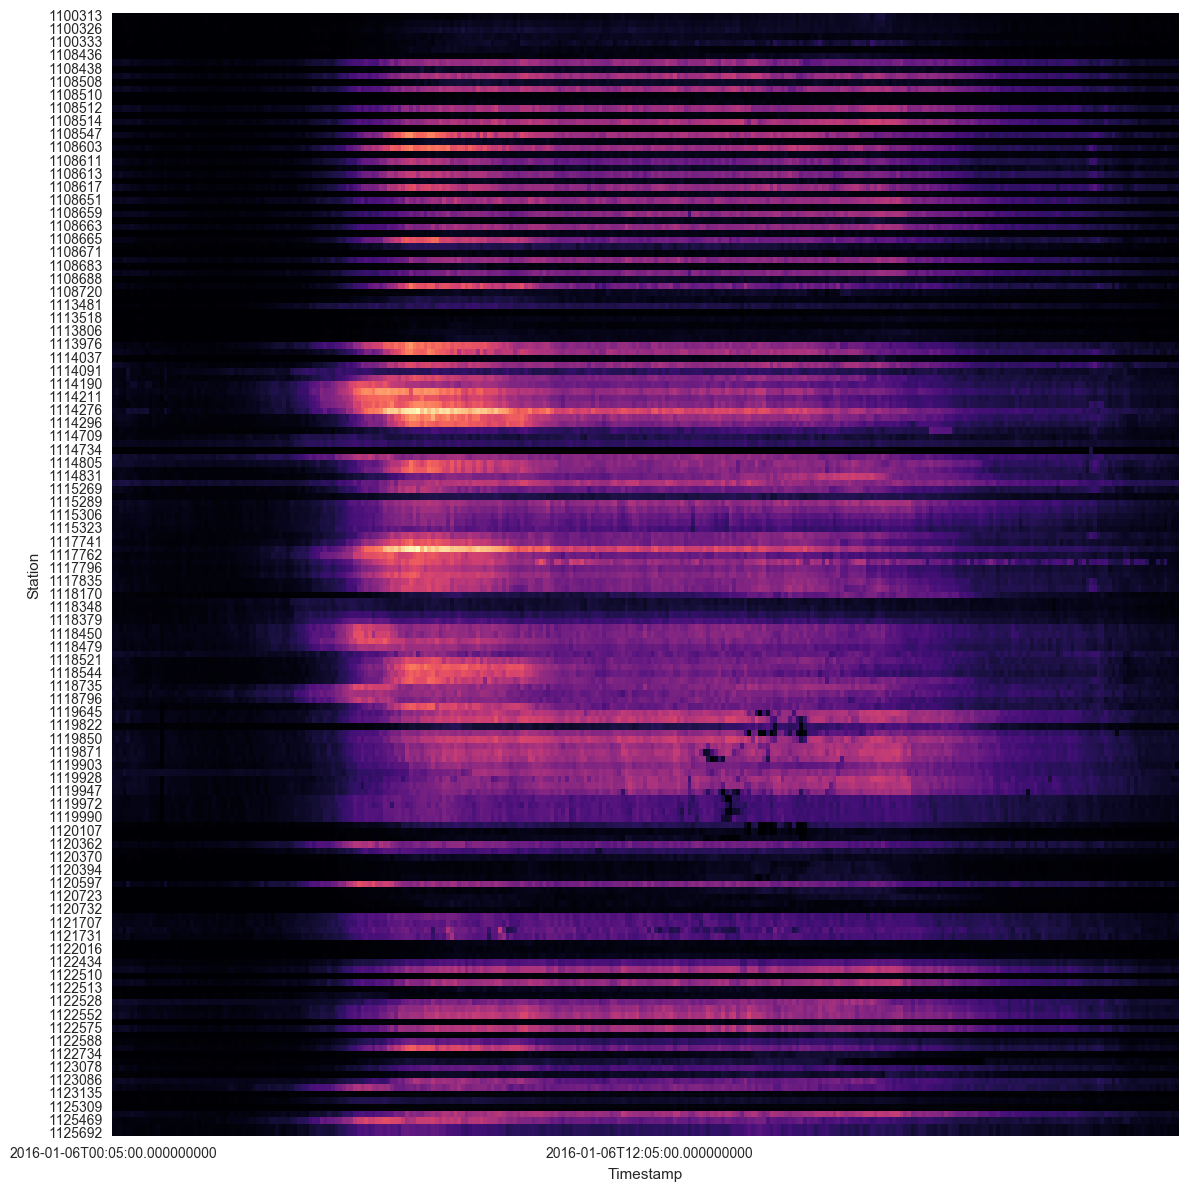

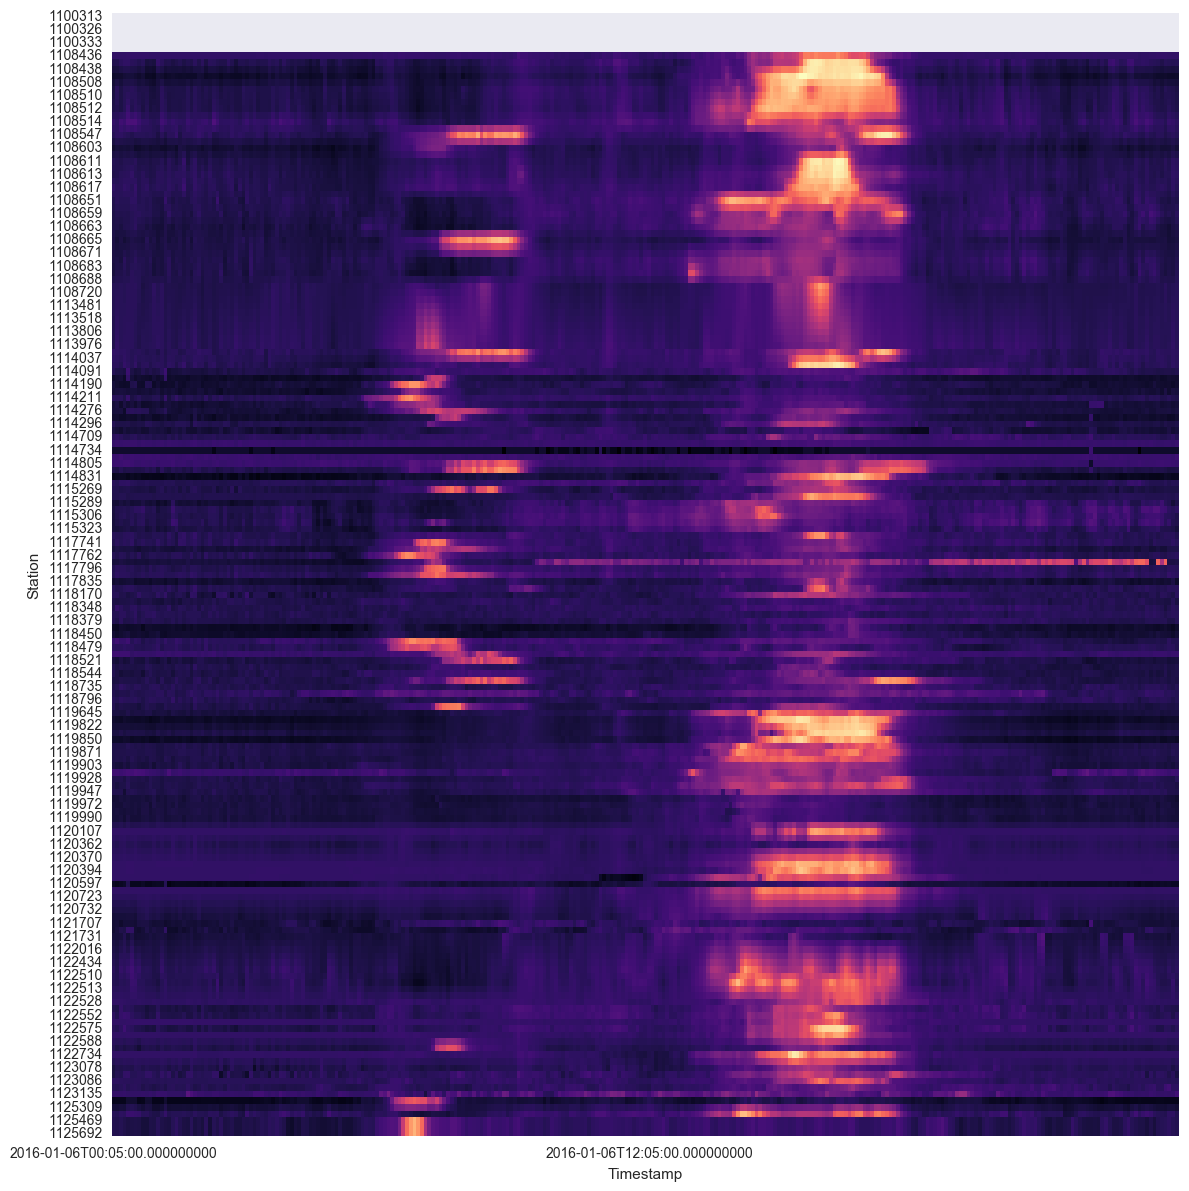

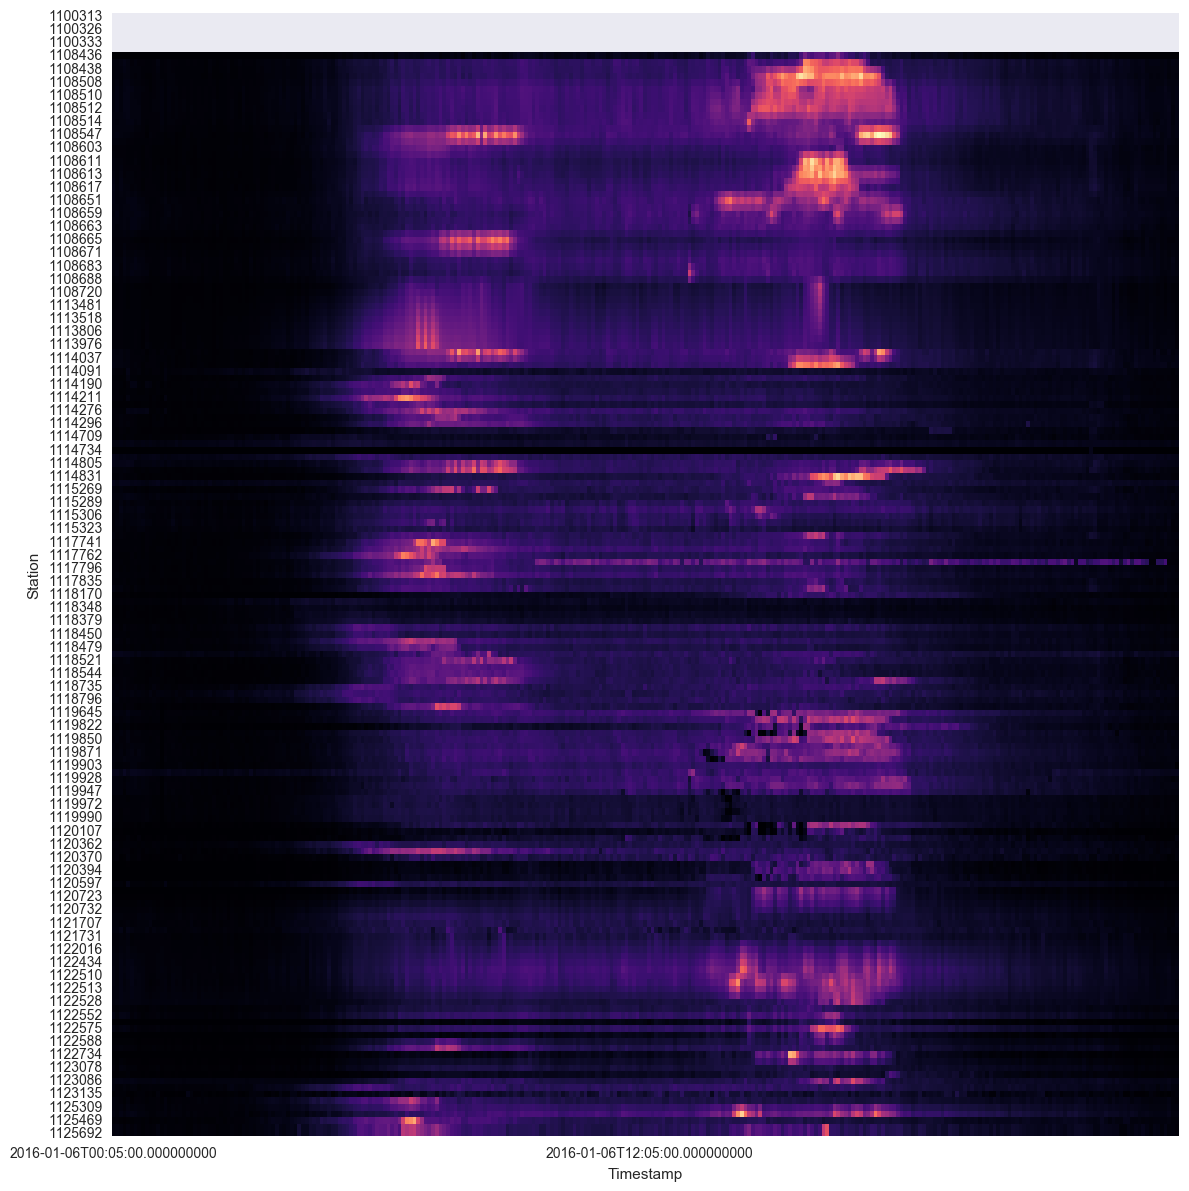

In [136]:
#draw heatmap of data
def plot_traffic_heat(data, cmap='magma'):
    
    f, ax = plt.subplots(figsize=(12, 12))

    sns.heatmap(data, square=False, xticklabels=12*12, yticklabels=2, cbar=False, cmap=cmap)#, center = 65)

    for item in ax.get_yticklabels():
        item.set_rotation(0)

    f.tight_layout()
    


r = get_timeslice(df,start_date='01/6/2016', end_date='01/6/2016', on='TotalFlow')#.dropna(axis=0, how='all')
r = r.apply(pd.Series.interpolate)
plot_traffic_heat(r)

r = get_timeslice(df,start_date='01/6/2016', end_date='01/6/2016', on='AvgSpeed')#.dropna(axis=0, how='all')
r = r.apply(pd.Series.interpolate)
plot_traffic_heat(r, cmap='magma_r')

r = get_timeslice(df,start_date='01/6/2016', end_date='01/6/2016', on='AvgOccupancy')#.dropna(axis=0, how='all')
r = r.apply(pd.Series.interpolate)
plot_traffic_heat(r)

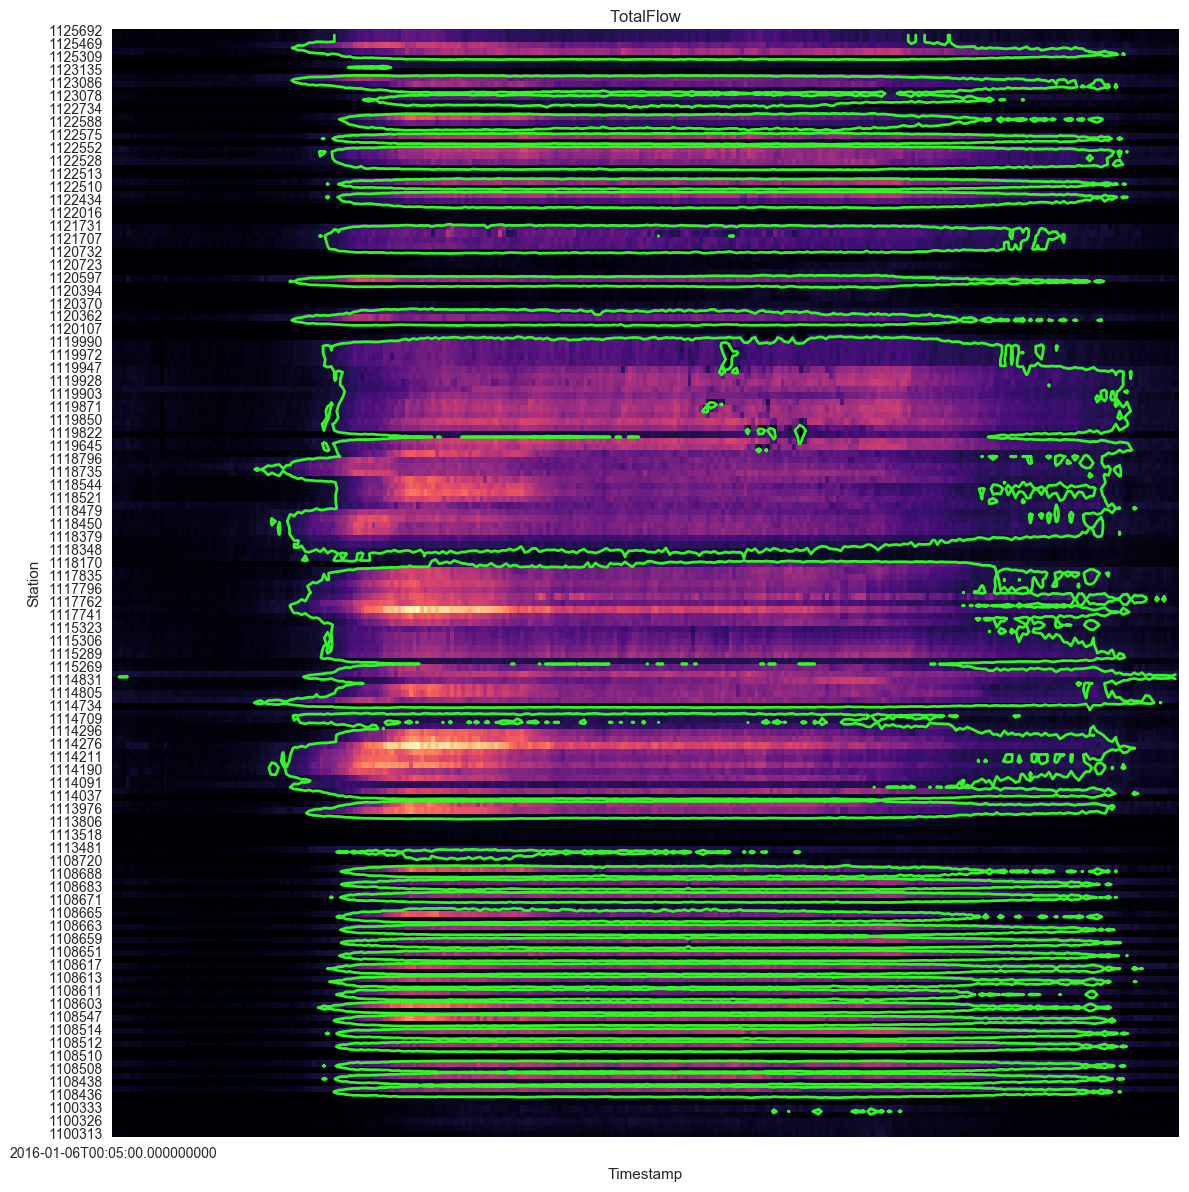

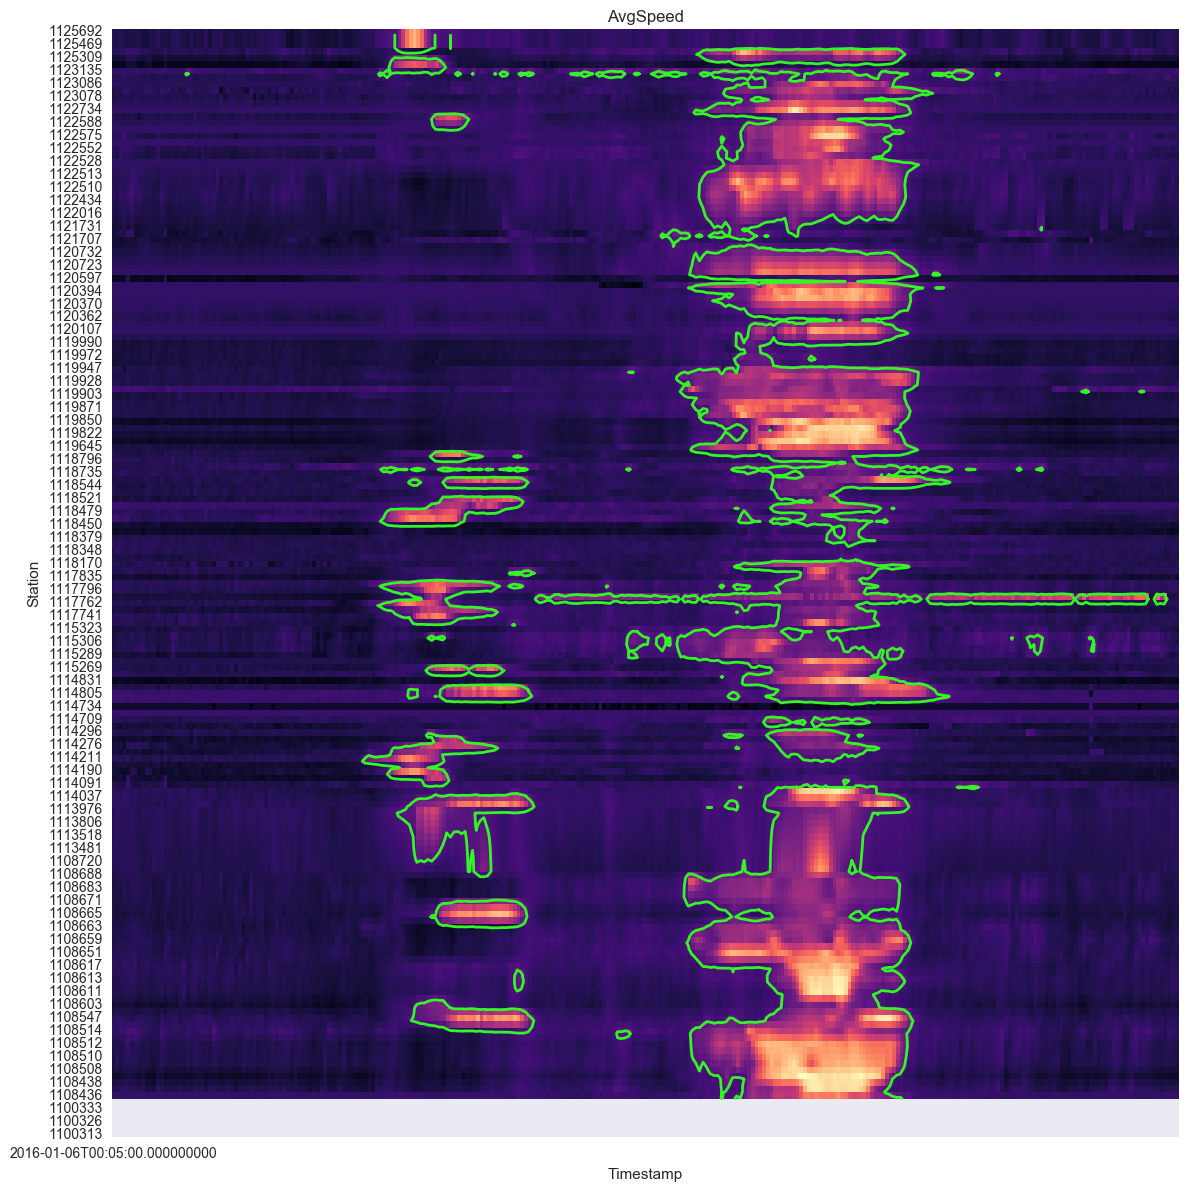

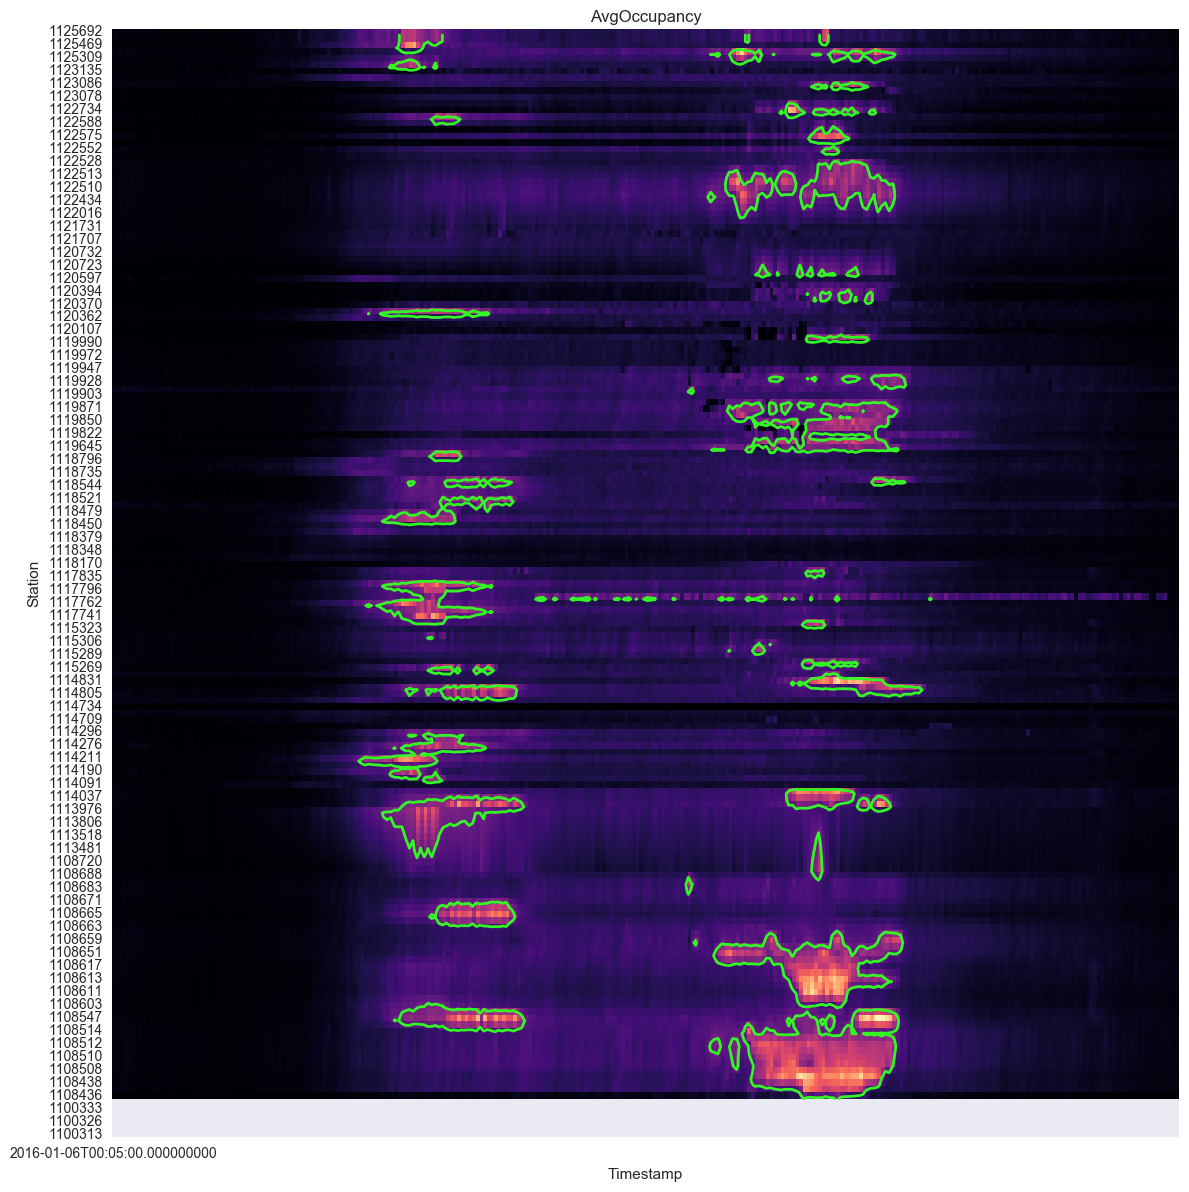

In [169]:
def plot_contours(r, threshold, cmap='magma',title=""):

    contours = measure.find_contours(r, threshold, fully_connected='high')

    # Display the image and plot all contours found
    f, ax = plt.subplots(figsize=(12, 12))
    
    ax.set_title(title)
    
    sns.heatmap(r[::-1], square=False, xticklabels=12*24, yticklabels=2, cbar=False, cmap=cmap)#, center = 65)

    # turn the axis label
    for item in ax.get_yticklabels():
        item.set_rotation(0)


    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color = '#33f725')

    f.tight_layout()


r = get_timeslice(df,start_date='01/6/2016', end_date='01/6/2016', on='TotalFlow')#.dropna(axis=0, how='all')
r = r.apply(pd.Series.interpolate)
plot_contours(r, 120, title="TotalFlow")

r = get_timeslice(df,start_date='01/6/2016', end_date='01/6/2016', on='AvgSpeed')#.dropna(axis=0, how='all')
r = r.apply(pd.Series.interpolate)
plot_contours(r, 60, cmap='magma_r', title="AvgSpeed")

r = get_timeslice(df,start_date='01/6/2016', end_date='01/6/2016', on='AvgOccupancy')#.dropna(axis=0, how='all')
r = r.apply(pd.Series.interpolate)
plot_contours(r,0.16, title="AvgOccupancy")

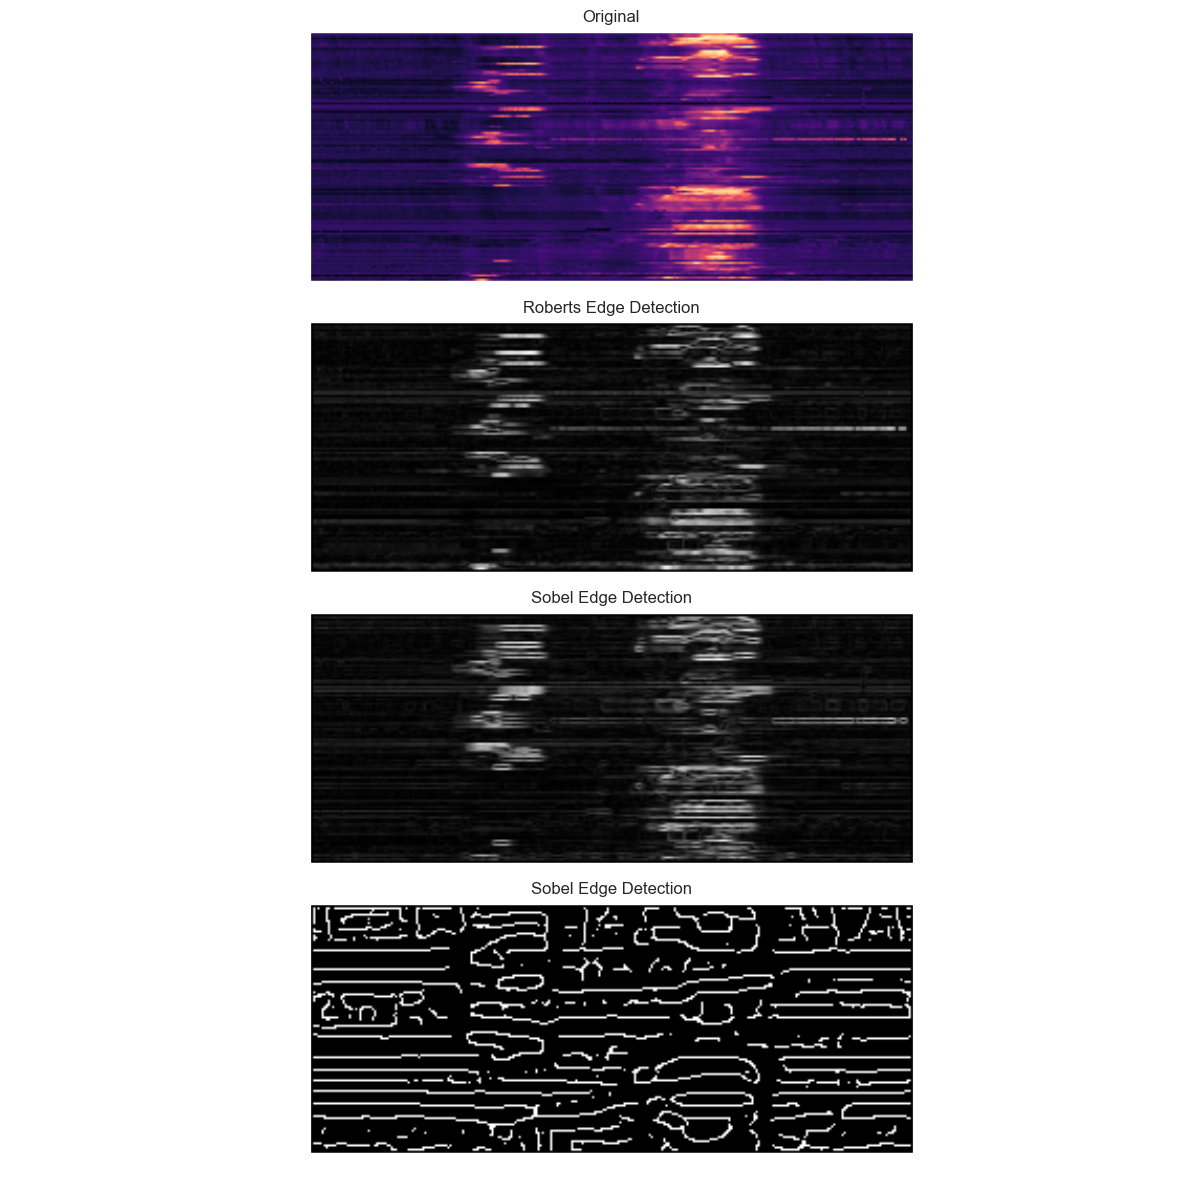

In [88]:
def plot_roberts_sobel(image):
    edge_roberts = roberts(image)
    edge_sobel = sobel(image)
    
    edge_canny = feature.canny(image, sigma=3)

    fig, ax = plt.subplots(nrows=4, sharex=True, sharey=True,
                           figsize=(12, 12))

    ax[0].imshow(image, cmap='magma_r')
    ax[0].set_title('Original')

    ax[1].imshow(edge_roberts, cmap=plt.cm.gray)
    ax[1].set_title('Roberts Edge Detection')

    ax[2].imshow(edge_sobel, cmap=plt.cm.gray)
    ax[2].set_title('Sobel Edge Detection')
    
    ax[3].imshow(edge_canny, cmap=plt.cm.gray)
    ax[3].set_title('Canny Edge Detection')

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()
    
r = get_timeslice(df,start_date='01/6/2016', end_date='01/6/2016').dropna(axis=0, how='all').values
plot_roberts_sobel(r)

In [44]:
#find all on ramps

def get_on_ramps(file_content):
    ramps = file_content.loc[file_content['LaneType']=='OR',:]

    interested_columns = ['Timestamp', 'Station', 'District', 'Freeway',
                          'Direction_of_Travel', 'LaneType', 'Samples',
                          'Perc_Observed', 'TotalFlow']
    
    print "good measure:",ramps.loc[:,'TotalFlow'].notnull().sum(), "total:", len(ramps)
    return ramps.loc[ramps.loc[:,'TotalFlow'].notnull(), interested_columns]


def get_off_ramps(file_content):
    ramps = file_content.loc[file_content['LaneType']=='FR',:]

    interested_columns = ['Timestamp', 'Station', 'District', 'Freeway',
                          'Direction_of_Travel', 'LaneType', 'Samples',
                          'Perc_Observed', 'TotalFlow']
    
    print "good measure:",ramps.loc[:,'TotalFlow'].notnull().sum(), "total:",len(ramps)
    return ramps.loc[ramps.loc[:,'TotalFlow'].notnull(), interested_columns]

def get_bad_sensors(file_content, columns):
    file_content['bad_count'] = file_content.loc[:,columns].isnull().sum(axis=1)
    total_bad = file_content.groupby('Station')['bad_count'].sum().reset_index()
    bad_stations = total_bad[total_bad['bad_count'] > 0]['Station'].tolist()
    #file_content['bad_station'] = file_content['Station'].isin(bad_stations) 
    return bad_stations

def get_sensors(file_content):
    return file_content.loc[:,'Station'].unique()

#print get_on_ramps(file_content).head(3)
#print get_off_ramps(file_content).head(3)
#print len(get_bad_sensors(file_content,['TotalFlow']))
#print len(get_sensors(file_content))

## Combine all files into one dataframe

In [45]:
df_list = []
for i, filename in enumerate(onlyfiles):
    t1 = time.time()
    with gzip.open(data_5min_path+filename, 'rb') as f:
        file_content = pd.read_csv(f,header=None,names=colnames)
        df_list.append(file_content)
    t2 = time.time()
    print i, filename, t2-t1
    
big_df = pd.concat(df_list)

0 d11_text_station_5min_2016_01_01.txt.gz 1.975274086
1 d11_text_station_5min_2016_01_02.txt.gz 1.8627550602
2 d11_text_station_5min_2016_01_03.txt.gz 1.90108704567
3 d11_text_station_5min_2016_01_04.txt.gz 1.97073101997
4 d11_text_station_5min_2016_01_05.txt.gz 2.01978898048
5 d11_text_station_5min_2016_01_06.txt.gz 2.14403009415
6 d11_text_station_5min_2016_01_07.txt.gz 2.60277199745
7 d11_text_station_5min_2016_01_08.txt.gz 2.851541996
8 d11_text_station_5min_2016_01_09.txt.gz 3.19061589241
9 d11_text_station_5min_2016_01_10.txt.gz 1.81436896324
10 d11_text_station_5min_2016_01_11.txt.gz 1.86859893799
11 d11_text_station_5min_2016_01_12.txt.gz 1.8681769371
12 d11_text_station_5min_2016_01_15.txt.gz 1.8702878952
13 d11_text_station_5min_2016_01_16.txt.gz 1.90073990822
14 d11_text_station_5min_2016_01_17.txt.gz 1.80181717873
15 d11_text_station_5min_2016_01_18.txt.gz 1.78451490402
16 d11_text_station_5min_2016_01_19.txt.gz 1.86002016068
17 d11_text_station_5min_2016_01_20.txt.gz 1.730

In [46]:
big_df.shape

(9842688, 52)

In [47]:
big_df.loc[:,'Timestamp'] = pd.to_datetime(big_df.loc[:,'Timestamp'],format='%m/%d/%Y %H:%M:%S')

In [48]:
big_df.head(3)

Timestamp  Station  District  Freeway Direction_of_Travel LaneType  \
0 2016-01-01  1100313        11        5                   N       FR   
1 2016-01-01  1100323        11        5                   N       FR   
2 2016-01-01  1100326        11        5                   N       FR   

   StationLength  Samples  Perc_Observed  TotalFlow       ...        \
0            NaN       10            100        8.0       ...         
1            NaN       20              0        NaN       ...         
2            NaN       20            100       12.0       ...         

   Lane7_Samples  Lane7_Flow  Lane7_AvgOcc  Lane7_AvgSpeed  Lane7_Observed  \
0            NaN         NaN           NaN             NaN               0   
1            NaN         NaN           NaN             NaN               0   
2            NaN         NaN           NaN             NaN               0   

   Lane8_Samples  Lane8_Flow  Lane8_AvgOcc  Lane8_AvgSpeed  Lane8_Observed  
0            NaN         NaN           NaN             NaN               0  
1            NaN         NaN           NaN             NaN               0  
2            NaN         NaN           NaN             NaN               0  

[3 rows x 52 columns]

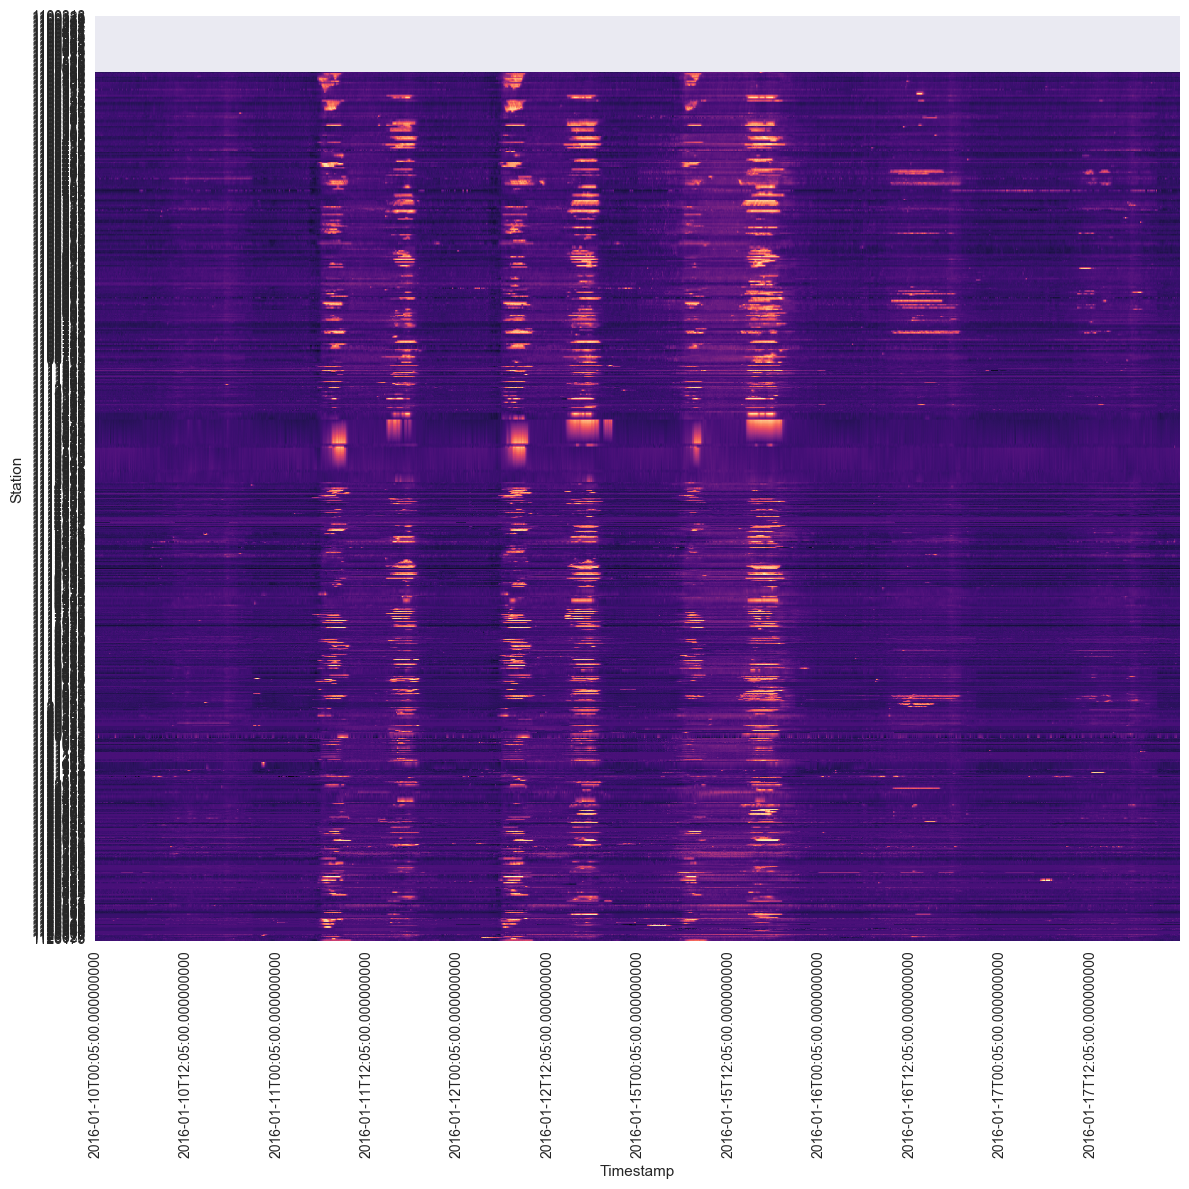

In [171]:
r = get_timeslice(big_df,start_date='01/10/2016', end_date='01/17/2016', on='AvgSpeed')#.dropna(axis=0, how='all')
r = r.apply(pd.Series.interpolate)
plot_traffic_heat(r, cmap='magma_r')

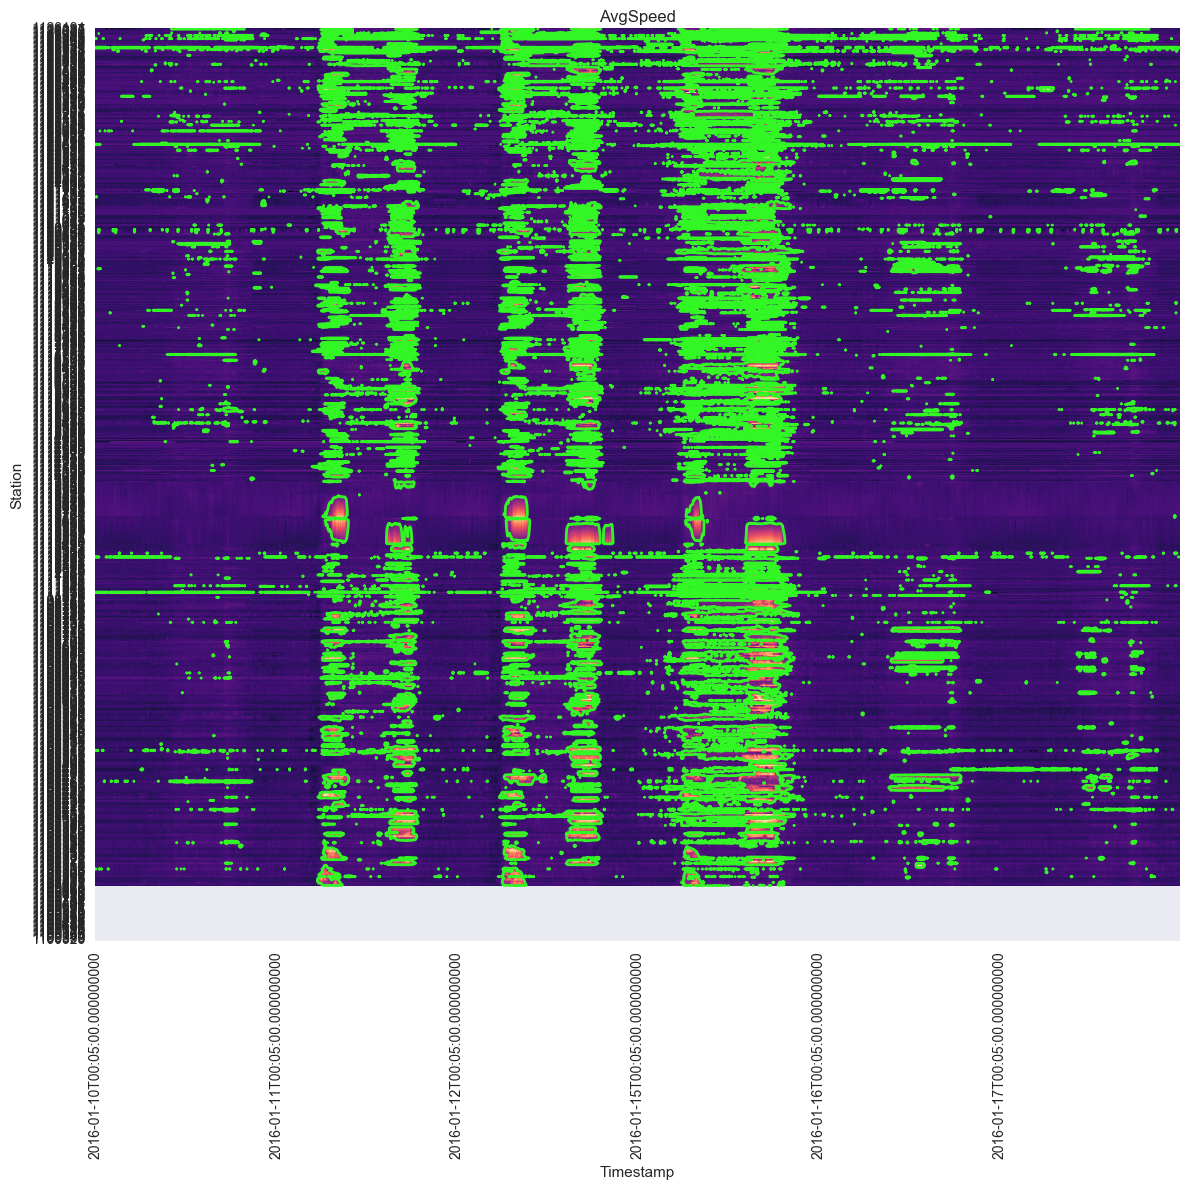

In [172]:
plot_contours(r, 60, cmap='magma_r', title="AvgSpeed")